# Figure 2: ER Doc Antibiotic Selection Patterns

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/conorcorbin/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-jonc101' 
client=bigquery.Client()

/Users/conorcorbin/opt/anaconda3/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [62]:
query = """
SELECT
    om.anon_id, om.pat_enc_csn_id_coded, om.order_med_id_coded, l.index_time, om.med_description,
    l.Ampicillin, l.Ciprofloxacin, l.Cefazolin, l.Ceftriaxone, l.Cefepime, l.Zosyn, l.Vancomycin,
    l.Meropenem, l.Vancomycin_Meropenem, l.Vancomycin_Zosyn, l.Vancomycin_Cefepime, l.Vancomycin_Ceftriaxone
FROM
    `mining-clinical-decisions.abx.abx_orders_given_and_stopped` om
INNER JOIN 
    `mining-clinical-decisions.abx.final_ast_labels` l
USING
    (pat_enc_csn_id_coded)
WHERE
    om.was_given = 1
ORDER BY 
    om.anon_id, om.pat_enc_csn_id_coded, om.order_time
"""
query_job = client.query(query)
df = query_job.result().to_dataframe()
df.head()

,anon_id,pat_enc_csn_id_coded,order_med_id_coded,index_time,med_description,Ampicillin,Ciprofloxacin,Cefazolin,Ceftriaxone,Cefepime,Zosyn,Vancomycin,Meropenem,Vancomycin_Meropenem,Vancomycin_Zosyn,Vancomycin_Cefepime,Vancomycin_Ceftriaxone
0,JC29f92d0,131265245074,603371616,2019-02-20 10:49:00+00:00,CEFTRIAXONE 1 GRAM/100 ML NS MINIBAG PLUS,0,0,0,0,0,1,0,1,1,1,0,0
1,JC29f92d0,131265245074,603374106,2019-02-20 10:49:00+00:00,PIPERACILLIN-TAZOBACTAM-DEXTRS 3.375 GRAM/50 M...,0,0,0,0,0,1,0,1,1,1,0,0
2,JC29f92d0,131265245074,603418477,2019-02-20 10:49:00+00:00,ERTAPENEM 1 GRAM/50 ML NS MINIBAG PLUS,0,0,0,0,0,1,0,1,1,1,0,0
3,JC29f9afd,131114292966,476869102,2015-09-03 14:08:00+00:00,VANCOMYCIN IN D5W 1 GRAM/200 ML IV PGBK,1,0,1,1,1,1,1,1,1,1,1,1
4,JC29f9afd,131114292966,476869103,2015-09-03 14:08:00+00:00,PIPERACILLIN-TAZOBACTAM-DEXTRS 4.5 GRAM/100 ML...,1,0,1,1,1,1,1,1,1,1,1,1


In [65]:
concat_abx = lambda x : ' '.join(np.unique(sorted([a for a in x])))
(df
.assign(med_description=lambda x: [a.split(' ')[0] for a in x.med_description])
.assign(med_description=lambda x: [(a.replace('PIPERACILLIN-TAZOBACTAM-DEXTRS','PIPERACILLIN-TAZOBACTAM')
                                    .replace('VANCOMYCIN-WATER', 'VANCOMYCIN'))
                                   for a in x.med_description])
.assign(index_time=lambda x: x.index_time.dt.year)
.groupby('pat_enc_csn_id_coded')
.agg(med_description=('med_description', concat_abx),
     year=('index_time', 'first'))
.reset_index()
.groupby(['year', 'med_description'])
.agg(num_distinct_csns=('pat_enc_csn_id_coded', 'nunique'))
.reset_index()
.sort_values(['year', 'num_distinct_csns'], ascending=False)
.query("year == '2019'")
).head(20)

,year,med_description,num_distinct_csns
1695,2019,CEFTRIAXONE,367
1794,2019,PIPERACILLIN-TAZOBACTAM VANCOMYCIN,113
1793,2019,PIPERACILLIN-TAZOBACTAM,102
1733,2019,CEFTRIAXONE PIPERACILLIN-TAZOBACTAM,41
1589,2019,AZITHROMYCIN CEFTRIAXONE,37
1734,2019,CEFTRIAXONE PIPERACILLIN-TAZOBACTAM VANCOMYCIN,32
1737,2019,CEFTRIAXONE VANCOMYCIN,31
1663,2019,CEFEPIME VANCOMYCIN,23
1765,2019,ERTAPENEM,23
1724,2019,CEFTRIAXONE METRONIDAZOLE,21


### For now only use CSNs with exact matches to our abx selections
Talk to Jon about this later, can we assume `PIPERACILLIN-TAZOBACTAM CEFTRIAXONE VANCOMYCIN` falls into the `PIPERACILLIN-TAZOBACTAM VANCOMYCIN` category for instance. 

In [85]:
from tqdm import tqdm
def compute_was_covered(x, random=False):
    """
    Given med description, find appropriate label column and return whether patient was covered during CSN
    Returns "Not in abx options" if abx regimen isn't in our set of 12 options - useful for filtering later
    """
    if not random:
        med_description = x.med_description
    else:
        med_description = x.random_med_description
        
    if med_description == "CEFTRIAXONE":
        return x.Ceftriaxone
    elif med_description == "PIPERACILLIN-TAZOBACTAM VANCOMYCIN":
        return x.Vancomycin_Zosyn
    elif med_description == "PIPERACILLIN-TAZOBACTAM":
        return x.Zosyn
    elif med_description == "CEFTRIAXONE VANCOMYCIN":
        return x.Vancomycin_Ceftriaxone
    elif med_description == "CEFEPIME VANCOMYCIN":
        return x.Vancomycin_Cefepime
    elif med_description == "CEFEPIME":
        return x.Cefepime
    elif med_description == "VANCOMYCIN":
        return x.Vancomycin
    elif med_description == "MEROPENEM":
        return x.Meropenem
    elif med_description == "MEROPENEM VANCOMYCIN":
        return x.Vancomycin_Meropenem
    elif med_description == "CEFAZOLIN":
        return x.Cefazolin
    elif med_description == "CIPROFLOXACIN":
        return x.Ciprofloxacin
    elif med_description == "AMPICILLIN":
        return x.Ampicillin
    else:
        return "Not in abx options"

df_final = pd.DataFrame()
clin_covered_rates = []
random_covered_rates = []
for i in tqdm(range(100)):
    # Aggregate clinician orders
    df_drugs = (df
        .assign(med_description=lambda x: [a.split(' ')[0] for a in x.med_description])
        .assign(med_description=lambda x: [(a.replace('PIPERACILLIN-TAZOBACTAM-DEXTRS','PIPERACILLIN-TAZOBACTAM')
                                            .replace('VANCOMYCIN-WATER', 'VANCOMYCIN'))
                                           for a in x.med_description])
        .assign(index_time=lambda x: x.index_time.dt.year)
        .groupby('pat_enc_csn_id_coded')
        .agg({'med_description' : concat_abx,
              'index_time' : 'first',
              'Ampicillin' : 'first',
              'Ciprofloxacin' : 'first',
              'Cefazolin' : 'first',
              'Ceftriaxone' : 'first',
              'Cefepime' : 'first',
              'Zosyn' : 'first',
              'Vancomycin' : 'first',
              'Meropenem' : 'first',
              'Vancomycin_Ceftriaxone' : 'first',
              'Vancomycin_Cefepime' : 'first',
              'Vancomycin_Zosyn' : 'first',
              'Vancomycin_Meropenem' : 'first'})
        .rename(columns={'index_time' : 'year'})
        .reset_index()    
    )

    # Create flag for whether clinicians covered the patient during the csn, then filter for 
    df_drugs = (df_drugs
        .query("year == 2019")
        .sample(frac=1.0, replace=True) # bootstrap each iteration
        .assign(was_covered_dr=df_drugs.apply(lambda x: compute_was_covered(x), axis=1))
        .query("was_covered_dr == 1 or was_covered_dr == 0")
        .assign(random_med_description=lambda x: np.random.choice(x.med_description, size=len(x.med_description), replace=False))
    )

    # create a column for a randomly shuffled med description and then compute when random assignemnt covers patient
    df_drugs = (df_drugs
        .assign(was_covered_random=df_drugs.apply(lambda x: compute_was_covered(x, random=True), axis=1))
        .groupby(['med_description'])
        .agg(num_distinct_csns=('pat_enc_csn_id_coded', 'count'),
             num_times_covered_dr=('was_covered_dr', 'sum'),
             num_times_covered_random=('was_covered_random', 'sum'))
        .reset_index()
        .sort_values(['num_distinct_csns'], ascending=False)
    )
    
    clin_covered_rate = df_drugs['num_times_covered_dr'].sum() / df_drugs['num_distinct_csns'].sum()
    random_covered_rate = df_drugs['num_times_covered_random'].sum() / df_drugs['num_distinct_csns'].sum()
    clin_covered_rates.append(clin_covered_rate)
    random_covered_rates.append(random_covered_rate)
    
    df_final = pd.concat([df_final, df_drugs])






  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:00<01:00,  1.65it/s]


  2%|▏         | 2/100 [00:01<01:02,  1.56it/s]


  3%|▎         | 3/100 [00:01<01:00,  1.61it/s]


  4%|▍         | 4/100 [00:02<00:58,  1.65it/s]


  5%|▌         | 5/100 [00:03<00:55,  1.72it/s]


  6%|▌         | 6/100 [00:03<00:56,  1.66it/s]


  7%|▋         | 7/100 [00:04<00:57,  1.60it/s]


  8%|▊         | 8/100 [00:04<00:57,  1.61it/s]


  9%|▉         | 9/100 [00:05<00:55,  1.63it/s]


 10%|█         | 10/100 [00:06<00:55,  1.64it/s]


 11%|█         | 11/100 [00:06<00:54,  1.63it/s]


 12%|█▏        | 12/100 [00:07<00:52,  1.66it/s]


 13%|█▎        | 13/100 [00:07<00:52,  1.64it/s]


 14%|█▍        | 14/100 [00:08<00:56,  1.51it/s]


 15%|█▌        | 15/100 [00:09<00:56,  1.49it/s]


 16%|█▌        | 16/100 [00:10<00:54,  1.55it/s]


 17%|█▋        | 17/100 [00:10<00:53,  1.55it/s]


 18%|█▊        | 18/100 [00:11<00:53,  1.54it/s]


 19%|█▉        | 19/100 [00:12<00:53,  1.50it/

In [90]:
print("Clinician Coverage Rate:{:.2f} [{:.2f}-{:.2f}]".format(np.mean(clin_covered_rates),
                                                              np.percentile(clin_covered_rates, 2.5),
                                                              np.percentile(clin_covered_rates, 97.5))
     )

print("Random Coverage Rate:{:.2f} [{:.2f}-{:.2f}]".format(np.mean(random_covered_rates),
                                                           np.percentile(random_covered_rates, 2.5),
                                                           np.percentile(random_covered_rates, 97.5))
     )


Clinician Coverage Rate:0.84 [0.81-0.86]
Random Coverage Rate:0.78 [0.75-0.81]


### Figure 2 Plot

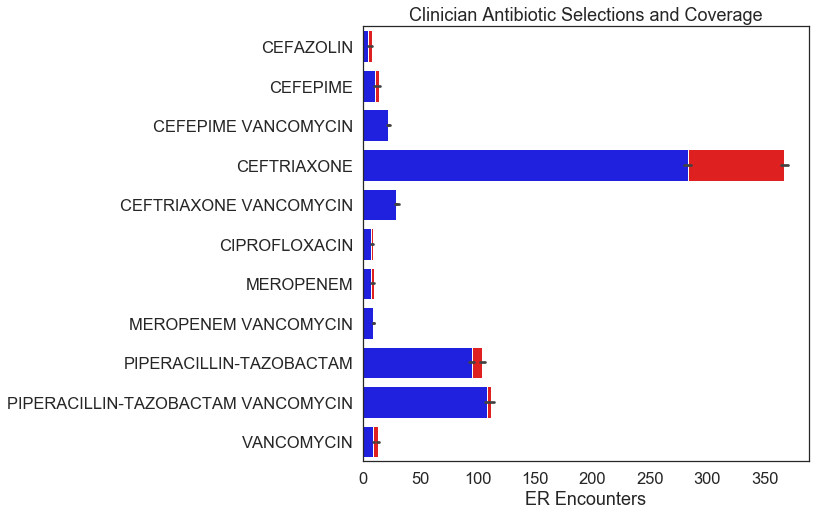

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.set(style='white', font_scale=1.5)
df_final = df_final.sort_values('med_description')
sns.barplot(x="num_distinct_csns", y="med_description", ci= data=df_final, ax=ax, color='red' )
sns.barplot(x="num_times_covered_dr", y="med_description", data=df_final, ax=ax, color='blue')
ax.set_ylabel("")
ax.set_xlabel("ER Encounters")
ax.set_title("Clinician Antibiotic Selections and Coverage")
plt.show()

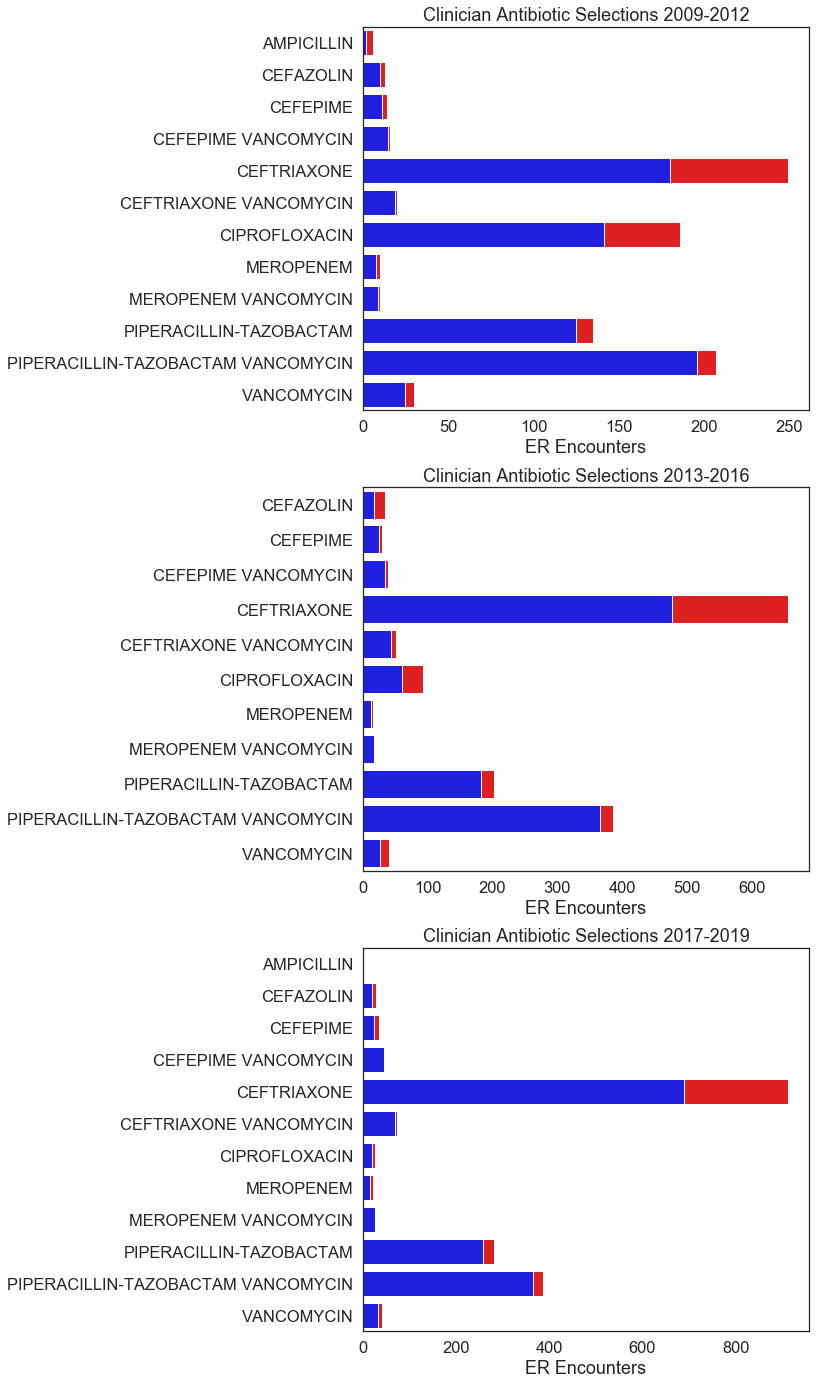

In [60]:
# Plot
import pdb
year_sets = [["2009", "2010", "2011", "2012"],
             ["2013", "2014", "2015", "2016"],
             ["2017", "2018", "2019"]]

fig, ax = plt.subplots(3, 1, figsize=(8, 24))
sns.set(style='white', font_scale=1.5)
row, col = 0, 0
for i, ys in enumerate(year_sets):
    df_year = (df_drugs
        .query("year in @ys", engine='python')
        .groupby("med_description")
        .agg({'num_distinct_csns' : 'sum',
              'num_times_covered' : 'sum'})
        .reset_index()
    )
    sns.barplot(x="num_distinct_csns", y="med_description", data=df_year, ax=ax[i], color='red')
    sns.barplot(x="num_times_covered", y="med_description", data=df_year, ax=ax[i], color='blue')
    ax[i].set_ylabel("")
    ax[i].set_xlabel("ER Encounters")
    ax[i].set_title("Clinician Antibiotic Selections %s-%s" % (ys[0], ys[-1]))
plt.show()

In [ ]:
### 